               time  temperature_2m (°C)  relativehumidity_2m (%)  \
0  1996-01-01T00:00                 -2.3                       80   
1  1996-01-01T01:00                 -2.1                       80   
2  1996-01-01T02:00                 -2.0                       79   
3  1996-01-01T03:00                 -2.1                       79   
4  1996-01-01T04:00                 -2.2                       78   

   dewpoint_2m (°C)  apparent_temperature (°C)  pressure_msl (hPa)  \
0              -5.3                       -7.2              1003.4   
1              -5.2                       -7.0              1003.8   
2              -5.2                       -6.9              1003.9   
3              -5.3                       -7.0              1004.0   
4              -5.5                       -7.1              1004.5   

   surface_pressure (hPa)  precipitation (mm)  rain (mm)  snowfall (cm)  ...  \
0                   988.2                 0.0        0.0            0.0  ...   
1   

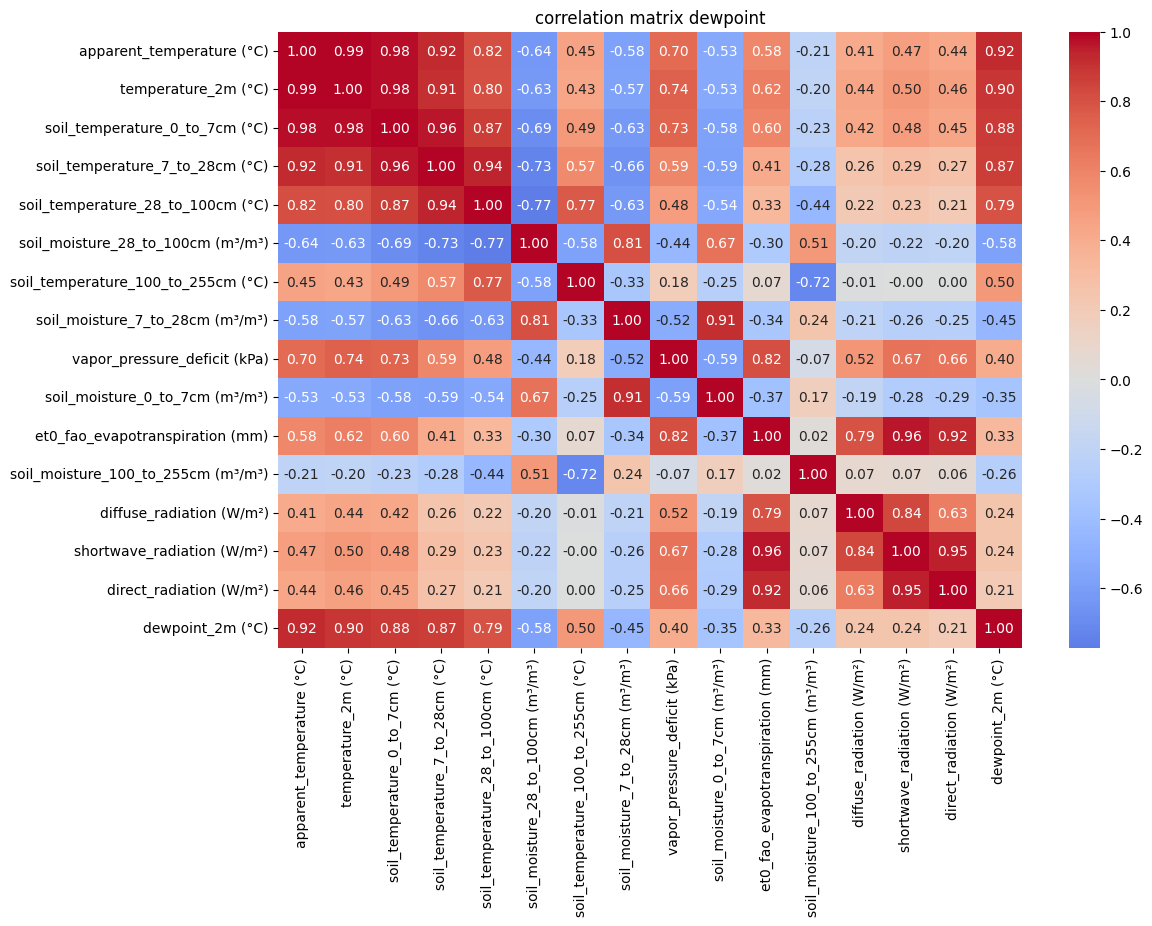


selected features for dewpoint:
['apparent_temperature (°C)', 'temperature_2m (°C)', 'soil_temperature_0_to_7cm (°C)', 'soil_temperature_7_to_28cm (°C)', 'soil_temperature_28_to_100cm (°C)', 'soil_moisture_28_to_100cm (m³/m³)', 'soil_temperature_100_to_255cm (°C)', 'soil_moisture_7_to_28cm (m³/m³)', 'vapor_pressure_deficit (kPa)', 'soil_moisture_0_to_7cm (m³/m³)', 'et0_fao_evapotranspiration (mm)']


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)


dewpoint results:
r2 train: 0.9681
r2 test: 0.9684


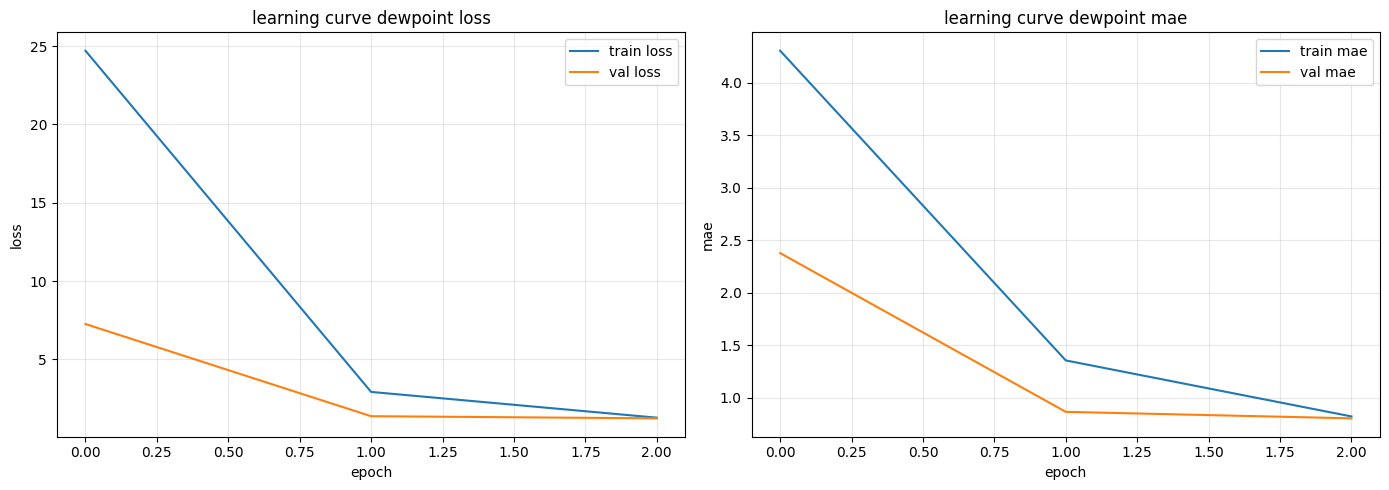


correlations with snowfall:
snowfall (cm)                        1.000000
weathercode (wmo code)               0.299132
precipitation (mm)                   0.177701
cloudcover_mid (%)                   0.151412
apparent_temperature (°C)            0.145608
temperature_2m (°C)                  0.142825
soil_temperature_7_to_28cm (°C)      0.137320
soil_temperature_0_to_7cm (°C)       0.137279
dewpoint_2m (°C)                     0.131738
soil_temperature_28_to_100cm (°C)    0.121669
surface_pressure (hPa)               0.110343
pressure_msl (hPa)                   0.104226
cloudcover (%)                       0.102447
cloudcover_low (%)                   0.097186
soil_moisture_28_to_100cm (m³/m³)    0.094069
Name: snowfall (cm), dtype: float64

selected features for snowfall:
['weathercode (wmo code)', 'precipitation (mm)', 'cloudcover_mid (%)', 'apparent_temperature (°C)', 'temperature_2m (°C)', 'soil_temperature_7_to_28cm (°C)', 'soil_temperature_0_to_7cm (°C)', 'dewpoint_2m (°C)', 

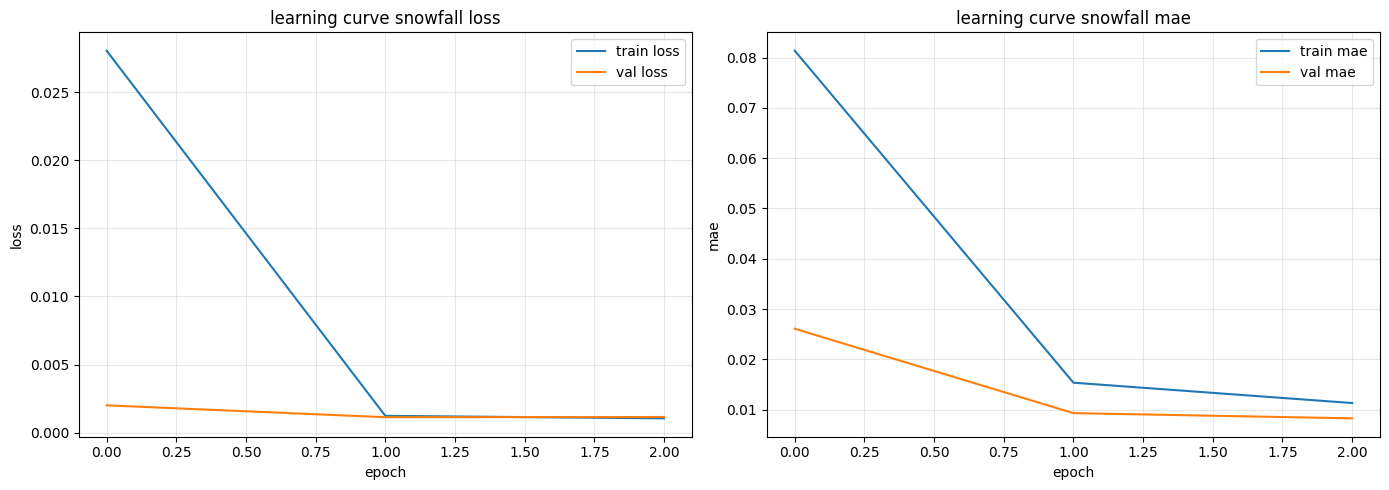


explanation:
snowfall prediction is worse than dewpoint because:
- snowfall is rare event (mostly 0)
- weak linear correlations
- non-linear relationships
- linear regression unsuitable for skewed data

done


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# load data
df = pd.read_csv('rawdata_luftqualitaet.csv')
print(df.head())
print(df.shape)

# select features
features = ['temperature_2m (°C)', 
            'relativehumidity_2m (%)', 
            'dewpoint_2m (°C)',
            'apparent_temperature (°C)', 
            'pressure_msl (hPa)', 
            'surface_pressure (hPa)', 
            'precipitation (mm)', 
            'rain (mm)', 
            'snowfall (cm)',
            'weathercode (wmo code)',
            'cloudcover (%)',
            'cloudcover_low (%)',
            'cloudcover_mid (%)', 'cloudcover_high (%)', 'shortwave_radiation (W/m²)', 
            'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)', 
            'direct_normal_irradiance (W/m²)', 'windspeed_10m (km/h)',
            'windspeed_100m (km/h)', 'winddirection_10m (°)', 'winddirection_100m (°)', 
            'windgusts_10m (km/h)', 'et0_fao_evapotranspiration (mm)', 
            'vapor_pressure_deficit (kPa)', 'soil_temperature_0_to_7cm (°C)', 
            'soil_temperature_7_to_28cm (°C)', 'soil_temperature_28_to_100cm (°C)', 
            'soil_temperature_100_to_255cm (°C)', 'soil_moisture_0_to_7cm (m³/m³)',
            'soil_moisture_7_to_28cm (m³/m³)', 'soil_moisture_28_to_100cm (m³/m³)', 
            'soil_moisture_100_to_255cm (m³/m³)']

df_selected = df[features].copy()
df_selected = df_selected.dropna()

# dewpoint prediction
target_dewpoint = 'dewpoint_2m (°C)'
correlations_dewpoint = df_selected.corr()[target_dewpoint].abs().sort_values(ascending=False)
print('\ncorrelations with dewpoint:')
print(correlations_dewpoint)

# plot correlations
plt.figure(figsize=(12, 8))
top_features = correlations_dewpoint[1:16].index
sns.heatmap(df_selected[list(top_features) + [target_dewpoint]].corr(), 
            annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('correlation matrix dewpoint')
plt.show()

# select features with correlation > 0.3
selected_features_dewpoint = correlations_dewpoint[(correlations_dewpoint > 0.3) & 
                                                   (correlations_dewpoint.index != target_dewpoint)].index.tolist()
print('\nselected features for dewpoint:')
print(selected_features_dewpoint)

# prepare data
X_dewpoint = df_selected[selected_features_dewpoint]
y_dewpoint = df_selected[target_dewpoint]

X_train_dew, X_test_dew, y_train_dew, y_test_dew = train_test_split(
    X_dewpoint, y_dewpoint, test_size=0.2, random_state=42
)

# scaling
scaler_dew = StandardScaler()
X_train_dew_scaled = scaler_dew.fit_transform(X_train_dew)
X_test_dew_scaled = scaler_dew.transform(X_test_dew)

# build model
model_dewpoint = keras.Sequential([
    layers.Input(shape=(X_train_dew_scaled.shape[1],)),
    layers.Dense(1)
])

model_dewpoint.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_dewpoint.summary()

# train
epochs = 3
batch_size = 32

history_dewpoint = model_dewpoint.fit(
    X_train_dew_scaled, y_train_dew,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)

# calculate r2
y_pred_train_dew = model_dewpoint.predict(X_train_dew_scaled, verbose=0)
y_pred_test_dew = model_dewpoint.predict(X_test_dew_scaled, verbose=0)

r2_train_dew = r2_score(y_train_dew, y_pred_train_dew)
r2_test_dew = r2_score(y_test_dew, y_pred_test_dew)

print(f'\ndewpoint results:')
print(f'r2 train: {r2_train_dew:.4f}')
print(f'r2 test: {r2_test_dew:.4f}')

# plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_dewpoint.history['loss'], label='train loss')
axes[0].plot(history_dewpoint.history['val_loss'], label='val loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].set_title('learning curve dewpoint loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_dewpoint.history['mae'], label='train mae')
axes[1].plot(history_dewpoint.history['val_mae'], label='val mae')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('mae')
axes[1].set_title('learning curve dewpoint mae')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('learning_curves_dewpoint.png', dpi=300, bbox_inches='tight')
plt.show()

# snowfall prediction
target_snowfall = 'snowfall (cm)'
correlations_snowfall = df_selected.corr()[target_snowfall].abs().sort_values(ascending=False)
print('\ncorrelations with snowfall:')
print(correlations_snowfall.head(15))

selected_features_snowfall = correlations_snowfall[(correlations_snowfall > 0.1) & 
                                                   (correlations_snowfall.index != target_snowfall)].index.tolist()
print('\nselected features for snowfall:')
print(selected_features_snowfall)

if len(selected_features_snowfall) > 0:
    X_snowfall = df_selected[selected_features_snowfall]
    y_snowfall = df_selected[target_snowfall]
    
    X_train_snow, X_test_snow, y_train_snow, y_test_snow = train_test_split(
        X_snowfall, y_snowfall, test_size=0.2, random_state=42
    )
    
    scaler_snow = StandardScaler()
    X_train_snow_scaled = scaler_snow.fit_transform(X_train_snow)
    X_test_snow_scaled = scaler_snow.transform(X_test_snow)
    
    model_snowfall = keras.Sequential([
        layers.Input(shape=(X_train_snow_scaled.shape[1],)),
        layers.Dense(1)
    ])
    
    model_snowfall.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    history_snowfall = model_snowfall.fit(
        X_train_snow_scaled, y_train_snow,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    y_pred_train_snow = model_snowfall.predict(X_train_snow_scaled, verbose=0)
    y_pred_test_snow = model_snowfall.predict(X_test_snow_scaled, verbose=0)
    
    r2_train_snow = r2_score(y_train_snow, y_pred_train_snow)
    r2_test_snow = r2_score(y_test_snow, y_pred_test_snow)
    
    print(f'\nsnowfall results:')
    print(f'r2 train: {r2_train_snow:.4f}')
    print(f'r2 test: {r2_test_snow:.4f}')
    
    print('\nsnowfall statistics:')
    print(y_snowfall.describe())
    print(f'days with snow: {(y_snowfall > 0).sum() / len(y_snowfall) * 100:.2f}%')
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(history_snowfall.history['loss'], label='train loss')
    axes[0].plot(history_snowfall.history['val_loss'], label='val loss')
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')
    axes[0].set_title('learning curve snowfall loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history_snowfall.history['mae'], label='train mae')
    axes[1].plot(history_snowfall.history['val_mae'], label='val mae')
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('mae')
    axes[1].set_title('learning curve snowfall mae')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('learning_curves_snowfall.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\nexplanation:')
    print('snowfall prediction is worse than dewpoint because:')
    print('- snowfall is rare event (mostly 0)')
    print('- weak linear correlations')
    print('- non-linear relationships')
    print('- linear regression unsuitable for skewed data')
else:
    print('no features found')

print('\ndone')